/var/folders/pf/2wxkf2nx2nz2_y55fmyz8cn40000gn/T/ipykernel_13385/3192573168.py:41: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  annual_stats = df.groupby('Year').apply(lambda x: pd.Series({
/var/folders/pf/2wxkf2nx2nz2_y55fmyz8cn40000gn/T/ipykernel_13385/3192573168.py:26: FutureWarning: YF.download() has changed argument auto_adjust default to True
  mkt = yf.download(['^GSPC', '^VIX'], start=START, end=END, interval='1d')['Close']
[*********************100%***********************]  2 of 2 completed



SYSTEMIC DEBT PRESSURE, LIQUIDITY & MARKET VOLATILITY (2000-2026)
 Year  Gross_T  Churn_T  Churn_Pct  Net_Liq_T  Sys_Vel  Churn_Vel  M2V  ^GSPC  ^VIX
 2000     1.46     0.78      53.70       0.72     2.03       1.09 2.14  -9.27 23.32
 2001     2.13     1.22      57.12       0.72     2.97       1.69 2.03 -10.53 25.75
 2002     3.06     1.91      62.59       0.72     4.25       2.66 1.94 -23.80 27.29
 2003     3.41     2.08      60.98       0.74     4.61       2.81 1.92  22.32 21.98
 2004     3.75     2.27      60.52       0.77     4.84       2.93 1.96   9.33 15.48
 2005     3.38     2.05      60.56       0.81     4.16       2.52 2.00   3.84 12.81
 2006     3.40     2.06      60.66       0.84     4.02       2.44 2.00  11.78 12.81
 2007     3.51     2.12      60.36       0.87     4.02       2.43 1.97   3.65 17.54
 2008     6.32     3.55      56.20       1.20     5.27       2.96 1.84 -37.58 32.69
 2009     8.28     4.40      53.10       2.07     3.99       2.12 1.72  19.67 31.48
 2010    

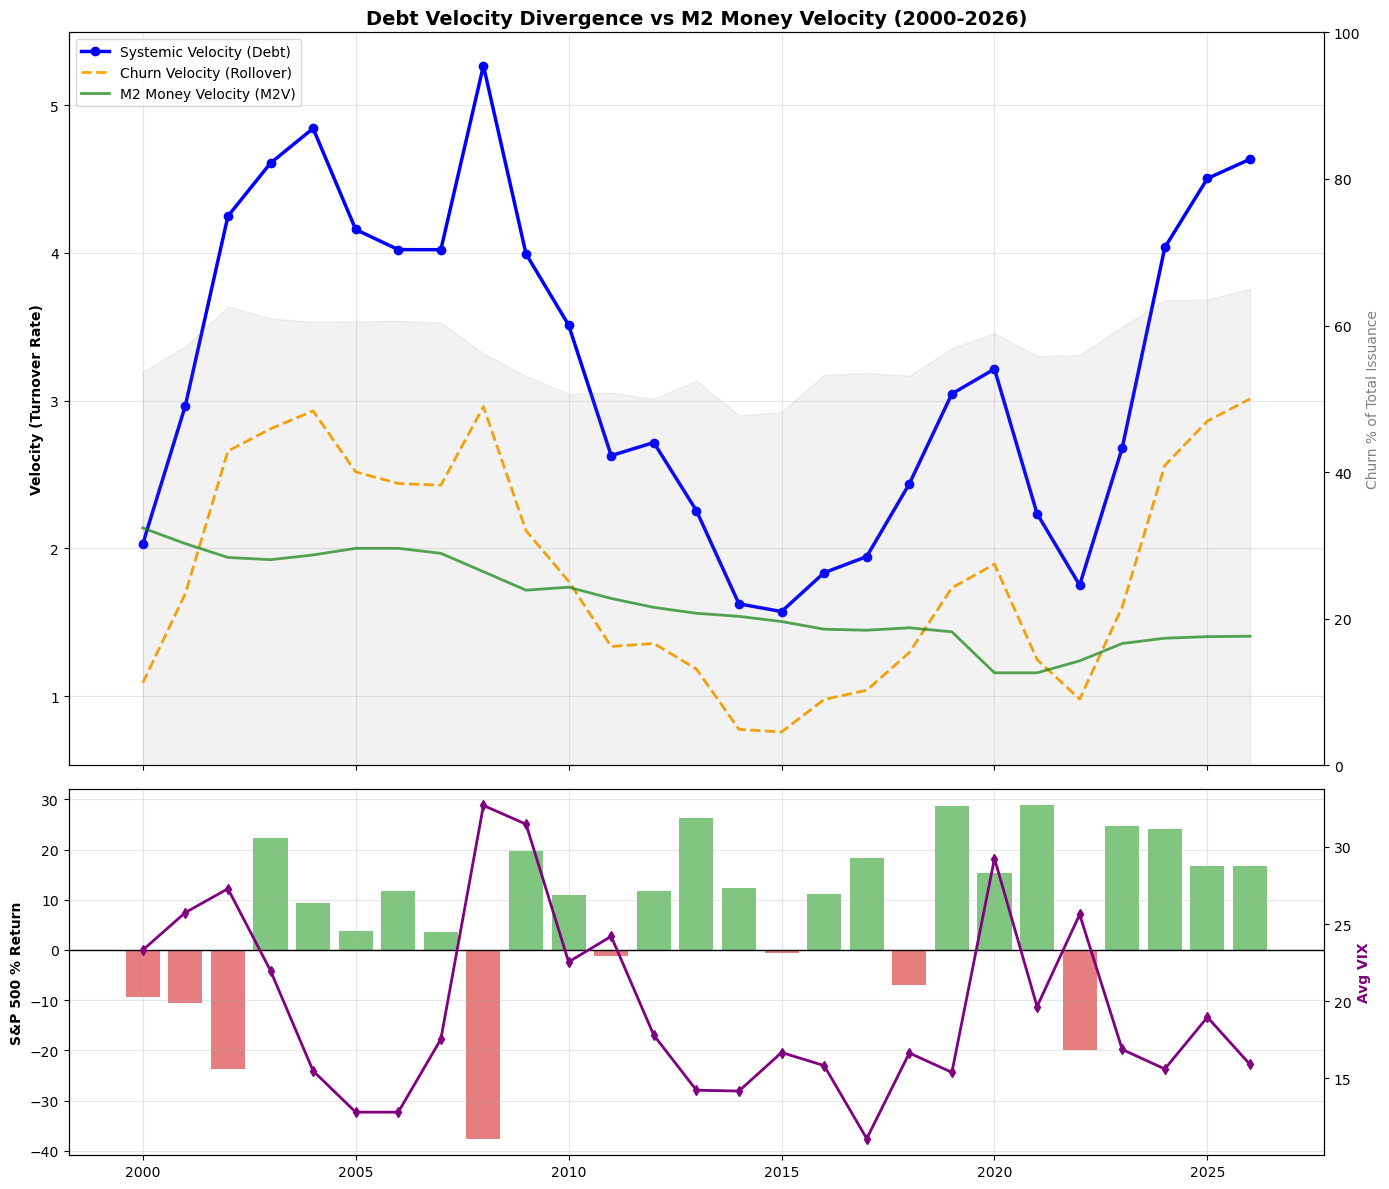

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_datareader.data as web
import yfinance as yf

# --- 1. DATA FETCHING & UNIT CORRECTION ---
START, END = "2000-01-01", "2026-12-31"

def get_market_and_macro():
    series = {'WALCL': 'Assets', 'RRPONTSYD': 'RRP', 'WTREGEN': 'TGA', 'M2V': 'M2V'}
    macro = web.DataReader(list(series.keys()), 'fred', START, END)
    
    # Fill early years: Pre-GFC, RRP and TGA were not used as active liquidity drains
    macro['RRPONTSYD'] = macro['RRPONTSYD'].fillna(0)
    macro['WTREGEN'] = macro['WTREGEN'].fillna(0)
    macro = macro.bfill().ffill()
    
    # HARD UNIT CORRECTION TO TRILLIONS ($T)
    assets_t = macro['WALCL'] / 1_000_000
    rrp_t = macro['RRPONTSYD'] / (1000 if macro['RRPONTSYD'].mean() > 100 else 1) / 1000
    tga_t = macro['WTREGEN'] / (1000 if macro['WTREGEN'].mean() > 100 else 1) / 1000
    macro['Net_Liq_T'] = (assets_t - rrp_t - tga_t).clip(lower=0.5)
    
    # MARKET DATA
    mkt = yf.download(['^GSPC', '^VIX'], start=START, end=END, interval='1d')['Close']
    
    macro_annual = macro.resample('YE').mean()
    mkt_annual = mkt.resample('YE').agg({'^GSPC': lambda x: (x.iloc[-1]/x.iloc[0]-1)*100, '^VIX': 'mean'})
    
    combined = pd.concat([macro_annual, mkt_annual], axis=1).ffill()
    combined['Year'] = combined.index.year
    return combined[['Year', 'Net_Liq_T', 'M2V', '^GSPC', '^VIX']]

# --- 2. PROCESS AUCTION DATA ---
df = pd.read_csv('Auctions_Query_20000101_20260202.csv')
df['Issue Date'] = pd.to_datetime(df['Issue Date'])
df['Maturity Date'] = pd.to_datetime(df['Maturity Date'])
df['Year'] = df['Issue Date'].dt.year

annual_stats = df.groupby('Year').apply(lambda x: pd.Series({
    'Gross_T': x['Offering Amount'].sum() / 1e12,
    'Churn_T': x[x['Issue Date'].dt.year == x['Maturity Date'].dt.year]['Offering Amount'].sum() / 1e12
})).reset_index()

# --- 3. MERGE & CALC METRICS ---
macro_mkt = get_market_and_macro()
results = pd.merge(annual_stats, macro_mkt, on='Year', how='right').ffill()

# 2026 Projections
idx_2026 = results[results['Year'] == 2026].index
if not idx_2026.empty:
    results.loc[idx_2026, 'Gross_T'] = 30.0
    results.loc[idx_2026, 'Churn_T'] = 19.5

results['Sys_Vel'] = results['Gross_T'] / results['Net_Liq_T']
results['Churn_Vel'] = results['Churn_T'] / results['Net_Liq_T']
results['Churn_Pct'] = (results['Churn_T'] / results['Gross_T']) * 100

# --- 4. OUTPUT UNIFIED TABLE ---
print("\n" + "="*120)
print("SYSTEMIC DEBT PRESSURE, LIQUIDITY & MARKET VOLATILITY (2000-2026)")
print("="*120)
# M2V explicitly added here:
final_table = results[['Year', 'Gross_T', 'Churn_T', 'Churn_Pct', 'Net_Liq_T', 'Sys_Vel', 'Churn_Vel', 'M2V', '^GSPC', '^VIX']]
pd.set_option('display.max_rows', None)
pd.set_option('display.width', 1000)
print(final_table.round(2).to_string(index=False))
print("="*120)

# --- 5. TWO-PANELED VISUALIZATION ---
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12), sharex=True, gridspec_kw={'height_ratios': [2, 1]})

# TOP PANE: Debt Velocity vs M2 Velocity
ax1.plot(results['Year'], results['Sys_Vel'], label='Systemic Velocity (Debt)', color='blue', lw=2.5, marker='o')
ax1.plot(results['Year'], results['Churn_Vel'], label='Churn Velocity (Rollover)', color='orange', ls='--', lw=2)
ax1.plot(results['Year'], results['M2V'], label='M2 Money Velocity (M2V)', color='green', lw=2, alpha=0.7)

# Shading for Churn % (Background context)
ax1_twin = ax1.twinx()
ax1_twin.fill_between(results['Year'], results['Churn_Pct'], color='gray', alpha=0.1, label='Churn %')
ax1_twin.set_ylabel('Churn % of Total Issuance', color='gray', fontsize=10)
ax1_twin.set_ylim(0, 100)

ax1.set_ylabel('Velocity (Turnover Rate)', fontweight='bold')
ax1.set_title('Debt Velocity Divergence vs M2 Money Velocity (2000-2026)', fontsize=14, fontweight='bold')
ax1.legend(loc='upper left')
ax1.grid(True, alpha=0.3)

# BOTTOM PANE: S&P 500 & VIX
ax2.bar(results['Year'], results['^GSPC'], color=np.where(results['^GSPC'] > 0, '#2ca02c', '#d62728'), alpha=0.6, label='S&P 500 Return %')
ax3 = ax2.twinx()
ax3.plot(results['Year'], results['^VIX'], color='purple', label='Volatility (VIX)', lw=2, marker='d', markersize=5)
ax2.set_ylabel('S&P 500 % Return', fontweight='bold')
ax3.set_ylabel('Avg VIX', fontweight='bold', color='purple')
ax2.axhline(0, color='black', lw=1)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()